In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

from pathlib import Path

from pyfcd.fcd import calculate_carriers, fcd, normalize_image
from pyfcd.auxiliars import selectSquareROI, plot_fft, plot_height_field

from scipy.signal.windows import tukey
from scipy.signal import find_peaks
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage import filters
from tqdm import tqdm

plt.style.use(["science", "nature"])

In [34]:
def butterworth_mask(i_def, i_ref, threshold=0.5, cutoff_frequency_ratio=0.01, order=2, npad=0):
    i_filtered = filters.butterworth(
        i_def,
        cutoff_frequency_ratio=cutoff_frequency_ratio,
        order=order,
        high_pass=False,
        squared_butterworth=False,
        npad=npad,
    )
    mask = i_filtered > (np.max(i_filtered)*threshold + np.min(i_filtered)*(1-threshold))
    i_masked = i_def*mask + i_ref*(np.logical_not(mask))
    return mask, i_masked, i_filtered

def find_circle(data, radii, low=None, high=None, sigma=1.0, mask=None, show_edges=False, **canny_kwargs):
    edges = canny(data, sigma=sigma, low_threshold=low, high_threshold=high, use_quantiles=True, mask=mask)
    
    if show_edges:
        plt.imshow(edges)
        plt.show()

    hough_res = hough_circle(edges, radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, radii, total_num_peaks=1)
    return np.array([cx[0], cy[0]]), radii

In [4]:
## FCD SETUP
start = 1150
stop = 1350

hp = 0.1              # [m]
alpha = 0.25
hstar = hp*alpha      # [m]

PXtoM = None   # [m]
square_size = 2.2e-3  # [m]

scale_roi_kwargs = None # {"width": 500, "height": 500}
roi = None

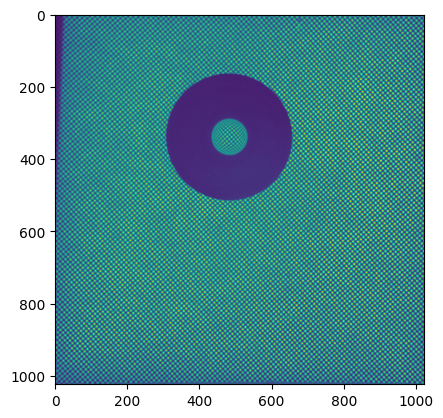

In [5]:
## UPLOADING

dir_path = globals()['_dh'][0]
images_path = dir_path.joinpath("Imagenes")
i_def_files = sorted([str(p) for p in images_path.glob("0611_toroide-forzado/i_defs/*.bmp")])[start:stop]

flag = cv2.IMREAD_UNCHANGED
i_ref = cv2.imread(str(images_path.joinpath("0611_toroide-forzado/i_ref.bmp")), flag)
i_defs = [cv2.imread(str(f), flag) for f in i_def_files]
plt.imshow(i_defs[0])

In [33]:
## FCD PROCESSING

delta=2
radii = np.arange(150, 200, 1)

height_fields = []
hs = []

i_filtered, mask, i_masked = masked_butterworth(i_defs[0], i_ref, threshold=0.6, order=2, cutoff_frequency_ratio=0.01, npad=32)
c, radii = find_circle(i_filtered, radii=radii, low=0.70, high=0.99, sigma=10)
R = int(radii[0] / np.sqrt(2))
x, y = c - R
w,  h = 2*R, 2*R

roi = x, y, w, h
window1dx = np.abs(tukey(roi[-1], 0.1))
window1dy = np.abs(tukey(roi[-2], 0.1))
window2d = np.sqrt(np.outer(window1dx, window1dy))


for i, i_def in tqdm(enumerate(i_defs)):
    mask, i_masked, i_filtered = butterworth_mask(i_def, i_ref, threshold=0.6, order=2, cutoff_frequency_ratio=0.01, npad=32)

    c, radii = find_circle(i_filtered, radii=radii, low=0.70, high=0.99, sigma=10)
    x, y = c - R

    cropped_ref = i_ref[y:y+h,x:x+w]*window2d
    cropped_def = i_masked[y:y+h,x:x+w]*window2d

    carriers = calculate_carriers(cropped_ref, PXtoM, square_size=square_size, show_carriers=False)
    height_field = fcd(cropped_def, carriers, h=hstar, unwrap=True, show_angles=False)

    hs.append(np.mean(height_field[R-delta:R+delta,R-delta:R+delta]))
    height_fields.append(height_field)

height_fields = np.array(height_fields)

200it [01:51,  1.80it/s]


In [36]:
def video_freq_projection(frames, fps, T=None, m=None): 
    """
    frames : ndarray
        3D numpy array with time dimension corresponding to axis 0. 
    fps : float
        frames per second
    T : float
        Time period (in seconds) of the desired frequency.
    """
    N  = len(frames)
    ts = range(len(frames))

    if T is None and m is None:
        projected_video = np.mean(frames, axis=0)

    elif m is None: 
        m = T*fps
    
    An = np.sum([frames[t]*np.exp(-1j*2*np.pi*t/m) for t in ts], axis=0) / N
    projected_video = np.real(np.array([An*np.exp(1j*2*np.pi*t/m) for t in ts]))

    return projected_video

def video_fft(frames, fps=1, apply_fftshift=False):
    frames_fft = rfft(frames, axis=0)
    freqs = rfftfreq(len(frames), 1/fps)
    return freqs, frames_fft

def video_ifft(freqs, frames_fft, fps=1, freq_loc=None, sigmas=1):
    if freq_loc is not None:
        delta = (freqs[1] - freqs[0])*sigmas
        mask = np.zeros_like(frames_fft)
        mask[np.abs(np.abs(freqs) - freq_loc) < delta,:,:] = 1
        frames_fft = mask*frames_fft

    video_ifft = irfft(frames_fft, axis=0)
    ts = np.arange(len(frames_fft))/fps
    return ts, video_ifft

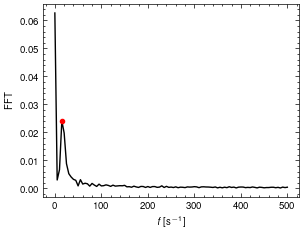

Con video_fft


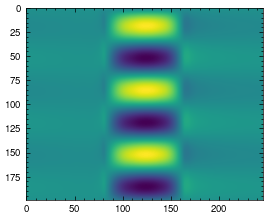

Con video_freq_projection


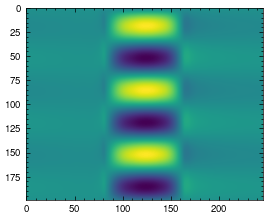

In [39]:
height_fields = np.array(height_fields)
vid_length, vid_width, vid_height =  height_fields.shape
R = vid_width // 2

freqs, vidfft = video_fft(height_fields, fps=1000, apply_fftshift=True)

peaks,_ = find_peaks(np.abs(vidfft[:,R,R]), height=0.02)
f = freqs[peaks][0]  # guarda frecuencia pico

plt.plot(freqs, np.abs(vidfft[:,R,R]), color="k")
plt.plot(freqs[peaks], np.abs(vidfft[:,R,R])[peaks], "o", color="r")
plt.xlabel(r"$f$ [s$^{-1}$]")
plt.ylabel(r"FFT")
plt.show()

ts, vidifft = video_ifft(freqs, vidfft, fps=1000, freq_loc=f) # Transformada inversa quedandose con componentes en f

print("Con video_fft")
plt.imshow(vidifft[:,:,R])
plt.show()

projected_video = video_freq_projection(height_fields, 1000, T = 1/f)

print("Con video_freq_projection")
plt.imshow(projected_video[:,:,R])
plt.show()
